In [6]:

from models import *
from config import *

from datasets import *

import math

dataset = ToyData("train")

idx = [4, 7, 9, 11]
ims = torch.cat([dataset[i]["image"].unsqueeze(0) for i in idx])

print(ims.shape)

percept = PSGNet(config.imsize,3)


outputs = percept(ims)

def normalize_outputs(outputs):
    recons = outputs["recons"]
    B = recons[0].shape[0]
    W = int(math.sqrt(recons[0].shape[1]))

    clusters  = outputs["clusters"]
    features  = outputs["features"]
    centroids = outputs["centroids"]
    moments   = outputs["moments"]

    for item in clusters:print(item[0].shape, item[1].shape)

    level_reconstructions = [item.reshape([B,W,W,3]) for item in recons]

    return {"recons":level_reconstructions, 
    "clusters": clusters, 
    "features": features, 
    "centroids": centroids, 
    "moments": moments,
    "batch":outputs["batch"]}

outputs = normalize_outputs(outputs)
recons = outputs["recons"]

for i,item in enumerate(recons):print("level:{}".format(i),item.shape)



class AbstractNet(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.num_heads =8
        self.feature_decoder = nn.Transformer(nhead=16, num_encoder_layers=12,d_model = config.global_feature_dim,batch_first = True)
        self.spatial_decoder = nn.Transformer(nhead=16, num_encoder_layers=12,d_model = config.global_feature_dim,batch_first = True)
        self.source_heads = nn.Parameter(torch.randn([self.num_heads,config.global_feature_dim]))

        self.coordinate_decoder = nn.Linear(config.global_feature_dim, 2)
    
    def forward(self, feature, spatial):
        B, M, C = feature.shape
        N = self.num_heads
        # [Feature Propagation]
        component_features = feature
        component_spaitals = spatial

        # [Decode Proposals]
        global_feature = torch.randn()
        source_heads = self.souce_heads
        feature_proposals = self.feature_decoder(source_heads,global_feature)
        spaital_proposals = self.spatial_decoder(source_heads,global_feature)

        # [Component Matching]
        # component_features : [B,M,C]
        # feature_proposals  : [B,N,C]

        match = torch.softmax(torch.einsum("bnc,bmc -> bnm",component_features, proposal_features)/math.sqrt(C), dim = -1)
        existence = torch.max(match, dim = 1).values  # [B, N, 1]

        # [Construct Representation]
        output_graph = 0

        return output_graph

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/melkor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


torch.Size([4, 128, 128, 3])
torch.Size([65536]) torch.Size([65536])
torch.Size([2198]) torch.Size([2198])
level:0 torch.Size([4, 128, 128, 3])
level:1 torch.Size([4, 128, 128, 3])


In [7]:
print("clusters")
clusters = outputs["clusters"]
for item in clusters:
    nodes = item[0]
    batch = item[1]
    print(nodes.shape, batch.shape)


print("features")
features = outputs["features"]
for item in features:
    print(item.shape)


print("centroids")
features = outputs["centroids"]
for item in features:
    print(item.shape)

print("moments")
features = outputs["moments"]
for item in features:
    print(item.shape)



clusters
torch.Size([65536]) torch.Size([65536])
torch.Size([2198]) torch.Size([2198])
features
torch.Size([2198, 64])
torch.Size([1021, 64])
centroids
torch.Size([2198, 2])
torch.Size([1021, 2])
moments
torch.Size([2198, 2])
torch.Size([1021, 2])


In [232]:
def to_dense_features(outputs, size = 128):
    level_batch = outputs["batch"]
    features = outputs["features"]
    centroids = outputs["centroids"]
    moments = outputs["moments"]
    clusters = outputs["clusters"]
    level_features = []
    for i in range(len(features)):
        sparse_feature = features[i]
        sparse_centroid = centroids[i]
        sparse_moment = moments[i]
    
        cast_batch = level_batch[i]

        feature,  batch = to_dense_batch(features[i],cast_batch)
        centroid, batch = to_dense_batch(centroids[i],cast_batch)
        moment,   _batch = to_dense_batch(moments[i],cast_batch)

        
        cluster_r = clusters[i][0]; 
        batch_r = clusters[i][1]
        for cluster_j,batch_j in reversed(clusters[:i]):
            cluster_r = cluster_r[cluster_j]
            batch_r = batch_r[batch_j]

        cluster_size = int(cluster_r.max()) + 1
        batch_size = int(cast_batch.max()) + 1
        local_masks = torch.zeros([batch_size*size * size, cluster_size])

        local_masks[cluster_r] = 1.0
        local_masks,batch = to_dense_batch(local_masks,batch_r)
        local_masks = local_masks[batch]
        print(local_masks.shape,batch.shape)

        local_masks = local_masks.reshape([batch_size, size, size, cluster_size]).permute([0,3,1,2])
        print(local_masks.shape,batch.shape)
        #print(cluster_r.shape)


        level_features.append({"features":feature, "centroids":centroid, "moments":moment,"masks":_batch.int(),"local_masks":local_masks})
    return level_features



In [233]:
psg_features = to_dense_features(outputs)

base_graph = psg_features[-1]


torch.Size([65536, 2198]) torch.Size([4, 16384])
torch.Size([4, 2198, 128, 128]) torch.Size([4, 16384])
torch.Size([65536, 1021]) torch.Size([4, 65536])
torch.Size([4, 1021, 128, 128]) torch.Size([4, 65536])


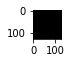

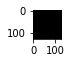

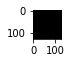

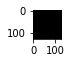

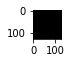

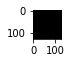

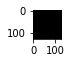

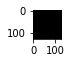

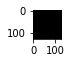

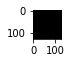

In [234]:
base = psg_features[-1]["local_masks"][1]
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.cla()
    plt.imshow(base[100+i],cmap="bone")
    plt.pause(0.01)

In [224]:
a = [27.2086, 19.4980, 20.4351, 29.7112, 20.9281, 21.2046, 28.7723, 40.6607,
         32.1640, 19.41741]

cnt = 0
for i in a:cnt += i
print(cnt)

260.00001000000003


In [89]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import os
import time
from torch_sparse import SparseTensor
import matplotlib.pyplot as plt


class GraphPropagation(nn.Module):
    def __init__(self,
                 num_iters=15,
                 excite=True,
                 inhibit=True,
                 project=False,
                 adj_thresh=0.5):
        super().__init__()
        self.num_iters = num_iters
        self.excite = excite
        self.inhibit = inhibit
        self.project = project
        self.adj_thresh = adj_thresh

        self.adj_e = None
        self.adj_i = None
        self.norm_factor_e = None
        self.norm_factor_i = None
        self.activation_converge = False

    def preprocess_inputs(self, h0, adj, activated):
        B, N, K = h0.shape

        # activated: binary tensor indicating nodes to start propagation from
        if activated is None: # randomly initialized at a point
            rand_idx = torch.randint(0, N, [B, ]).to(h0.device)
            activated = F.one_hot(rand_idx, num_classes=N).unsqueeze(-1).float()  # [BT, N, 1]
        else:
            activated = activated.reshape(B, N, 1)

        # create excitatory and inhibitory affinities, followed by thresholding
        if not isinstance(adj, SparseTensor): # dense tensor
            adj = adj.reshape(B, N, N)
            adj_e, adj_i = adj, 1.0 - adj
            if self.adj_thresh is not None:
                adj_e = self._threshold(adj_e, self.adj_thresh)
                adj_i = self._threshold(adj_i, self.adj_thresh)
            sample_mask = None
        else: # sparse tensor
            adj_e = adj
            adj_i = adj.copy().set_value_(1.0 - adj.storage.value())

            sample_mask = adj_e.copy()
            sample_mask = sample_mask.set_value_(torch.ones_like(sample_mask.storage.value()))

            if self.adj_thresh is not None:
                adj_e = self._threshold_sparse_tensor(adj_e, self.adj_thresh)
                adj_i = self._threshold_sparse_tensor(adj_i, self.adj_thresh)

        return h0, adj_e, adj_i, activated, sample_mask

    def forward(self, h0, adj, activated=None):
        """
        Function: Graph propagation to create the plateau map representation
        Input:
        - h0: initial hidden states (or equivalently, plateau map representation) with shape [B, N Q]
        - adj: affinity matrix with shape
        - activated: The graph propagation will start from the activated nodes
                   It can be None or binary tensor of shape [B, N].
                   If None, one node will be randomly selected as being activated
        Return:
        - plateau_map_list: a list of plateau maps of len self.num_iters. Each plateau map has shape [B, N, Q]
        """

        h0, adj_e, adj_i, activated, sample_mask = self.preprocess_inputs(h0, adj, activated)

        h = h0.clone()
        plateau_map_list = []
        running_activated = activated
        self.activation_converge = False

        # start graph propagation
        for it in range(self.num_iters):
            h, activated, running_activated = \
                self.propagate(h, adj_e, adj_i, activated, running_activated, sample_mask, it)
            plateau_map_list.append(h.reshape(h0.shape))

        return plateau_map_list

    def propagate(self, h, adj_e, adj_i, activated, running_activated, sample_mask, iter):
        B, N, D = h.shape

        # Graph propagation starts at a subset of activated nodes
        # If self.activation_converge is False, i.e. not all nodes are activated, \
        #   we need to apply masking to the affinities and compute the normalization factor accordingly.
        # We do so until all the nodes are activated, i.e.  self.activation_converge == True

        if not self.activation_converge:
            if isinstance(adj_e, SparseTensor):
                # apply the activation mask on the affinity tensors
                adj_e = adj_e.mul(activated.flatten()[None])
                adj_i = adj_i.mul(activated.flatten()[None])
                sample_mask = sample_mask.mul(activated.flatten()[None])

            # compute the normalization factors
            if not isinstance(adj_e, SparseTensor):
                norm_factor_e = torch.sum(adj_e.abs() * activated, dim=-2, keepdim=True).clamp(min=1.0).detach()
                norm_factor_i = torch.sum(adj_i.abs() * activated, dim=-2, keepdim=True).clamp(min=1.0).detach()
            else:
                norm_factor_e = adj_e.sum(1).reshape(B, N, 1).clamp(min=1.0).detach()
                norm_factor_i = adj_i.sum(1).reshape(B, N, 1).clamp(min=1.0).detach()

            self.norm_factor_e = norm_factor_e # [B,1,N]
            self.norm_factor_i = norm_factor_i # [B,1,N]
            self.adj_e = adj_e
            self.adj_i = adj_i

            self.activation_converge = activated.sum() == (B * N)
        else: # no update is required if all the nodes are activated
            adj_e = self.adj_e
            adj_i = self.adj_i
            norm_factor_e = self.norm_factor_e
            norm_factor_i = self.norm_factor_i
            sample_mask = None

        # [Excitation]
        if self.excite:
            if not isinstance(adj_e, SparseTensor):
                e_effects = torch.matmul(h.permute(0, 2, 1), adj_e * activated) / norm_factor_e
                e_effects = e_effects.permute(0, 2, 1)
            else:
                e_effects = adj_e.matmul(h.reshape(B * N, D))
                e_effects = e_effects.reshape(B, N, D) / norm_factor_e
            h = h + e_effects

        # [Inhibition]
        if self.inhibit:
            if not isinstance(adj_e, SparseTensor):
                i_effects = torch.matmul(h.permute(0, 2, 1), adj_i * activated) / norm_factor_i
                i_effects = i_effects.permute(0, 2, 1)
            else:
                i_effects = adj_i.matmul(h.reshape(B * N, D))
                i_effects = i_effects.reshape(B, N, D) / norm_factor_i

            proj = self._projection(h, i_effects) if self.project else i_effects
            h = h - proj

        h = self._relu_norm(h)

        # [Update activated nodes]
        if activated.sum() < B * N:
            if not isinstance(adj_e, SparseTensor):
                receivers = torch.max(torch.where(adj_e > adj_i, adj_e, adj_i) * activated, dim=1, keepdim=False)[0] > 0.5 # [B,N]
            else:
                assert sample_mask is not None
                receivers = sample_mask.max(dim=1) > 0.5
                receivers = receivers.reshape(B, N)

            running_activated = running_activated + receivers.unsqueeze(-1).float()
            activated = running_activated.clamp(max=1.0).detach()

        return h, activated, running_activated

    @staticmethod
    def _threshold(x, thresh):
        return x * (x > thresh).float()

    @staticmethod
    def _threshold_sparse_tensor(x, thresh):
        row, col, value = x.coo()
        valid = value > thresh
        sparse_size = [x.size(0), x.size(1)]
        output = SparseTensor(row=row[valid],col=col[valid],value=value[valid],sparse_sizes=sparse_size)
        return output

    @staticmethod
    def _projection(v, u, eps=1e-12):
        u_norm = torch.sum(u * u, -1, keepdims=True)
        dot_prod = torch.sum(v * u, -1, keepdims=True)
        proj = (dot_prod / (u_norm + eps)) * u
        return proj

    @staticmethod
    def _relu_norm(x, relu=True, norm=True, eps=1e-16):
        x = F.relu(x) if relu else x
        x = F.normalize(x + eps, p=2.0, dim=-1, eps=max([eps, 1e-12])) if norm else x
        return x


In [105]:
propagator = GraphPropagation(7)


feature = torch.randn([4,250,64])
adj = torch.ones([4,250*250, 1])

plateau_map = propagator(feature, adj)

print(len(plateau_map))
print(plateau_map[-1].shape)

7
torch.Size([4, 250, 64])


In [237]:
class AbstractNet(nn.Module):
    def __init__(self,dim = 72, width = 10, iters = 10):
        super().__init__()
        
        self.num_heads = width
        feature_dim = dim
        

        self.propagator = GraphPropagation(num_iters = iters)
        self.feature_heads = nn.Parameter(torch.randn([width, dim]))
        self.spatial_heads = nn.Parameter(torch.randn([width, 2]))

        self.transfer = FCBlock(100,1,dim,dim)


    def forward(self, input_graph):
        # [Feature Propagation]
        features =  input_graph["features"]
        spatials =  input_graph["centroids"]
        masks    =  input_graph["masks"]
        B, N, C = features.shape

        # [Build Adjacency Matric]
        adj = torch.ones([B,N,N,1])
        #TODO: implement a non trivial solution!
        #print("B:{} N:{} C:{}".format(B,N,C))
        """
        plateau_maps = self.propagator(features, adj)
        features = plateau_maps[-1]
        """

        # features after the graph propagation

        # [Decode the Matching Head for the input graph]
        # TODO: actually implement a version that is context dependent

        feature_proposals = self.feature_heads.unsqueeze(0).repeat(B, 1, 1)
        spatial_proposals = torch.sigmoid(self.spatial_heads).unsqueeze(0).repeat(B, 1, 1)

        # [Component Matching]

        # component_features : [B,N,C]
        component_features = torch.cat([features, spatials], -1)

        # feature_proposals  : [B,M,C]
        proposal_features = torch.cat([feature_proposals,spatial_proposals], -1)

 
        match = torch.softmax(masks.unsqueeze(-1) * torch.einsum("bnc,bmc -> bnm",component_features, proposal_features)/math.sqrt(C), dim = -1)
    

        output_features = torch.einsum("bnc,bnm->bmc",self.transfer(features), match)
        #print(torch.sum(match,-2))

        existence = torch.max(match, dim = 1).values

        #print("e:",existence)


        out_centroids = torch.einsum("bnk,bnm->bmk",spatials,match)

        # calculate the local mask for visualization

        #input_local_masks = input_graph["local_masks"]
        input_local_masks = torch.ones([B,N,128,128])
        #print(input_local_masks.shape)
        output_local_masks = torch.einsum("bnwh,bnm->bmwh",input_local_masks,match)

        output_graph = {"features":output_features, "centroids":out_centroids, "masks":existence, "edge":match, "local_masks":output_local_masks}
        return output_graph

test_net = AbstractNet(64, 10)

In [238]:
input_graph = base_graph
output_graph = test_net(input_graph)


output_masks = output_graph["local_masks"]
print(output_masks.shape)

B:4 N:260 C:64
tensor([[24.2960, 46.9277, 29.1820, 20.4438, 17.7945, 14.8668, 30.9136, 22.3007,
         30.7347, 22.5403],
        [24.4654, 45.8139, 28.6731, 20.5793, 18.0654, 15.3204, 30.7000, 22.4795,
         31.0686, 22.8344],
        [24.1466, 47.2655, 28.9958, 20.1783, 17.4926, 14.6230, 31.0297, 22.1647,
         31.5984, 22.5055],
        [24.3572, 47.9064, 28.7659, 20.0374, 17.1996, 14.3041, 31.2534, 22.1374,
         31.6785, 22.3602]], grad_fn=<SumBackward1>)
e: tensor([[0.1094, 0.2487, 0.1438, 0.1000, 0.1000, 0.1000, 0.1467, 0.1000, 0.1604,
         0.1000],
        [0.1107, 0.2399, 0.1381, 0.1000, 0.1000, 0.1000, 0.1467, 0.1000, 0.1604,
         0.1070],
        [0.1033, 0.2396, 0.1450, 0.1002, 0.1000, 0.1000, 0.1464, 0.1000, 0.1604,
         0.1000],
        [0.1127, 0.2353, 0.1405, 0.1056, 0.1000, 0.1000, 0.1464, 0.1000, 0.1604,
         0.1148]], grad_fn=<MaxBackward0>)
torch.Size([4, 260, 128, 128])
torch.Size([4, 10, 128, 128])


In [239]:
a = [24.2960, 46.9277, 29.1820, 20.4438, 17.7945, 14.8668, 30.9136, 22.3007,
         30.7347, 22.54031]

cnt = 0
for i in a:cnt += i
print(cnt)

260.00011


In [247]:
def Fact(n):
    if n == 1 or n == 0:
        return 1
    else:
        return Fact(n-1) * n

def C(n,r):
    return Fact(n)/(Fact(n-r) * Fact(r))



In [249]:
C(16,4) - C(15,3)

1365.0

In [251]:
(Fact(10) * Fact(10))/(Fact(10) + Fact(10))

1814400.0

In [252]:
1302884352000 - 1814400

1302882537600

In [253]:
(Fact(7) * Fact(5))/(Fact(7) + Fact(5))

117.20930232558139

In [254]:
Fact(8)

40320

In [269]:

(Fact(17+15))/(Fact(17) * Fact(15))

565722720.0

In [267]:
(Fact(17-7+15-5))/(Fact(17-7) * Fact(15-5))

184756.0

In [266]:
(Fact(7+5))/(Fact(7) * Fact(5))

792.0

In [268]:
792 * 184756

146326752

In [270]:
(Fact(17+15))/(Fact(17) * Fact(15)) - 792 * 184756

419395968.0

In [272]:
C(16,4) - C(15,3)

1365.0

In [273]:
Fact(8)

40320

In [275]:
7**4

2401

In [276]:
Fact(10) - Fact(8) * 6

3386880

In [7]:
ans = 0

prev1 = 1
prev2 = 2
nxt = prev1 + prev2

while nxt < 4000000:
    nxt = prev1 + prev2
    prev1 = prev2
    prev2 = nxt
    if nxt%2==0:
        print("yes")
        ans += nxt
        print(i,nxt)

print(ans + 2)


yes
39 8
yes
39 34
yes
39 144
yes
39 610
yes
39 2584
yes
39 10946
yes
39 46368
yes
39 196418
yes
39 832040
yes
39 3524578
4613732


In [1]:
from models import *
from config import *

model = AutoLearner(config)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/melkor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
pybullet build time: Oct 24 2022 03:35:20
/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


AttributeError: 'Namespace' object has no attribute 'nf_effect'